Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


### Данные

Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models.  

Three data sets are submitted, for training and testing. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute. 

Attribute Information:  

date time year-month-day hour:minute:second   
Temperature, in Celsius  
Relative Humidity, %  
Light, in Lux  
CO2, in ppm  
Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air  
Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status  




In [1]:
import xgboost
import catboost
import lightgbm
import shap
shap.initjs()
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

In [23]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
   
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train) 

        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions


def test_estimators(train,target,estimators,cv_strategy,metric,print_is = True):
    res_base ={}
    for n,e in estimators:
        if print_is:
            print()
            print(f'#########################################   {n}   ###################################################')
            print()
        res_base[n] = make_cross_validation(train,
                          target,
                          e,
                          metric,
                          cv_strategy,print_is = print_is)[1]
    return    res_base  


def feature_importances(estimator,columns,limit=None,is_print=True,graph = True):
    imported=estimator.feature_importances_
    imported = list(zip(columns[:limit],imported))
    if limit:
        imported = imported[:limit]    
    imported.sort(key = lambda x: x[1],reverse=True)  
    x = [i[0] for i in imported]
    y = [i[1] for i in imported]
    if is_print:
        print(imported)
    if graph:    
        fig = plt.figure(figsize=[20,10])
        plt.bar(x,y)
        plt.show()
    return imported    


def test_feature_importances(estimators,columns):
    imp_f={}
    for  n,e in estimators:
        print()
        print(f'#########################################   {n}   ###################################################')
        print()
        e.fit(X_train,y_train)
        pred = e.predict_proba(X_test)[:,1]
        print(f'roc_auc_score for -{n} :',roc_auc_score(y_test,pred))
        imp_f[n] = feature_importances(e,columns)
    return imp_f


def shap_plot_summary_for_several_models(estimators):
    for  n,e in estimators:
        print()
        print(f'#########################################   {n}   ###################################################')
        print()
        e.fit(X_train,y_train)
        explainer = shap.TreeExplainer(e)
        shap_values = explainer.shap_values(X_train)
        shap.summary_plot(shap_values, X_train)
        shap.summary_plot(shap_values, X_train, plot_type="bar")

In [3]:
df =pd.concat([pd.read_csv('datatraining.txt'),pd.read_csv('datatest.txt'),pd.read_csv('datatest2.txt')])

In [4]:
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.180,27.2720,426.00,721.25,0.004793,1
2,2015-02-04 17:51:59,23.150,27.2675,429.50,714.00,0.004783,1
3,2015-02-04 17:53:00,23.150,27.2450,426.00,713.50,0.004779,1
4,2015-02-04 17:54:00,23.150,27.2000,426.00,708.25,0.004772,1
5,2015-02-04 17:55:00,23.100,27.2000,426.00,704.50,0.004757,1
...,...,...,...,...,...,...,...
9748,2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.004213,1
9749,2015-02-18 09:16:00,20.865,27.7450,423.50,1514.50,0.004230,1
9750,2015-02-18 09:16:59,20.890,27.7450,423.50,1521.50,0.004237,1
9751,2015-02-18 09:17:59,20.890,28.0225,418.75,1632.00,0.004279,1


In [5]:
target='Occupancy'
to_drop=['date','Occupancy']

In [6]:
df.Occupancy.value_counts(normalize=True)

0    0.768969
1    0.231031
Name: Occupancy, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20560 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [9]:
df.date = pd.to_datetime(df.date)

In [10]:
df['day_of_month'] = df.date.dt.day
df['day_of_week'] = df.date.dt.dayofweek
df['day_of_year'] = df.date.dt.dayofyear
df['hours'] = df.date.dt.hour
df['minuts_from_start_day'] = df.date.dt.hour*60+df.date.dt.minute



In [11]:
df['day_hour'] = df.day_of_week*100+df.hours

In [12]:
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day_of_month,day_of_week,day_of_year,hours,minuts_from_start_day,day_hour
1,2015-02-04 17:51:00,23.180,27.2720,426.00,721.25,0.004793,1,4,2,35,17,1071,217
2,2015-02-04 17:51:59,23.150,27.2675,429.50,714.00,0.004783,1,4,2,35,17,1071,217
3,2015-02-04 17:53:00,23.150,27.2450,426.00,713.50,0.004779,1,4,2,35,17,1073,217
4,2015-02-04 17:54:00,23.150,27.2000,426.00,708.25,0.004772,1,4,2,35,17,1074,217
5,2015-02-04 17:55:00,23.100,27.2000,426.00,704.50,0.004757,1,4,2,35,17,1075,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9748,2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.004213,1,18,2,49,9,555,209
9749,2015-02-18 09:16:00,20.865,27.7450,423.50,1514.50,0.004230,1,18,2,49,9,556,209
9750,2015-02-18 09:16:59,20.890,27.7450,423.50,1521.50,0.004237,1,18,2,49,9,556,209
9751,2015-02-18 09:17:59,20.890,28.0225,418.75,1632.00,0.004279,1,18,2,49,9,557,209


In [13]:
estimators = [
              ('rf',RandomForestClassifier()),
              ('lgb',lightgbm.LGBMClassifier()),
              ('xgb',xgboost.XGBClassifier()),
              ('cb',catboost.CatBoostClassifier(verbose = False)) ]

In [14]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=100)

In [15]:
test_estimators(df.drop(to_drop,axis=1),df[target],estimators,cv_strategy,roc_auc_score,print_is = True)


#########################################   rf   ###################################################

Fold: 1, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score = 0.9998
Fold: 2, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score = 0.9996
Fold: 3, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score = 0.9985
Fold: 4, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score = 0.9995
Fold: 5, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score = 0.9997
CV-results train: 1.0 +/- 0.0
CV-results valid: 0.9994 +/- 0.0
OOF-score = 0.9994

#########################################   lgb   ###################################################

Fold: 1, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score = 0.9983
Fold: 2, train-observations = 16448, valid-observations = 4112
train-score = 1.0, valid-score

{'rf': 0.9994124038749627,
 'lgb': 0.9989749525616697,
 'xgb': 0.9990377575818103,
 'cb': 0.9990981324278438}

Какие прекрасные показатели точности :)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(to_drop,axis=1),df[target])

In [17]:
columns = X_train.columns.to_list()


#########################################   rf   ###################################################

roc_auc_score for -rf : 0.9997070599402877
[('Light', 0.5378573926814724), ('Temperature', 0.12065517406509468), ('CO2', 0.11651540542580624), ('minuts_from_start_day', 0.07513199281042698), ('hours', 0.05632897480129109), ('day_hour', 0.03161010346787045), ('day_of_week', 0.023966333371300445), ('HumidityRatio', 0.011643786719234052), ('Humidity', 0.011399896923153921), ('day_of_month', 0.008060568292023194), ('day_of_year', 0.006830371442326594)]


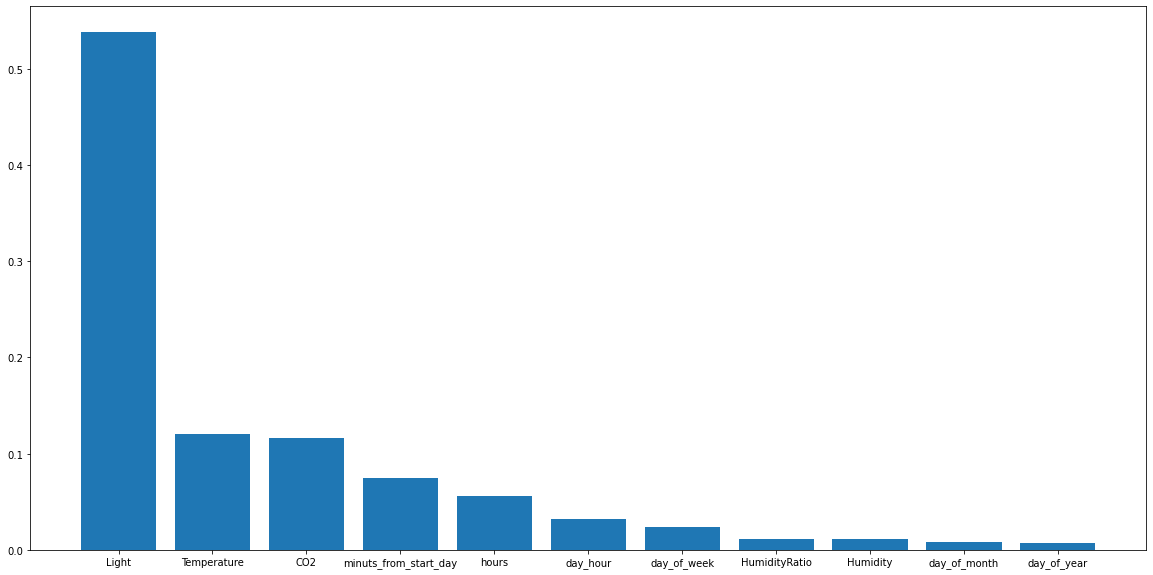


#########################################   lgb   ###################################################

roc_auc_score for -lgb : 0.9991755890354296
[('Light', 575), ('minuts_from_start_day', 538), ('CO2', 496), ('Temperature', 404), ('Humidity', 365), ('HumidityRatio', 317), ('day_hour', 152), ('day_of_week', 76), ('day_of_month', 53), ('hours', 24), ('day_of_year', 0)]


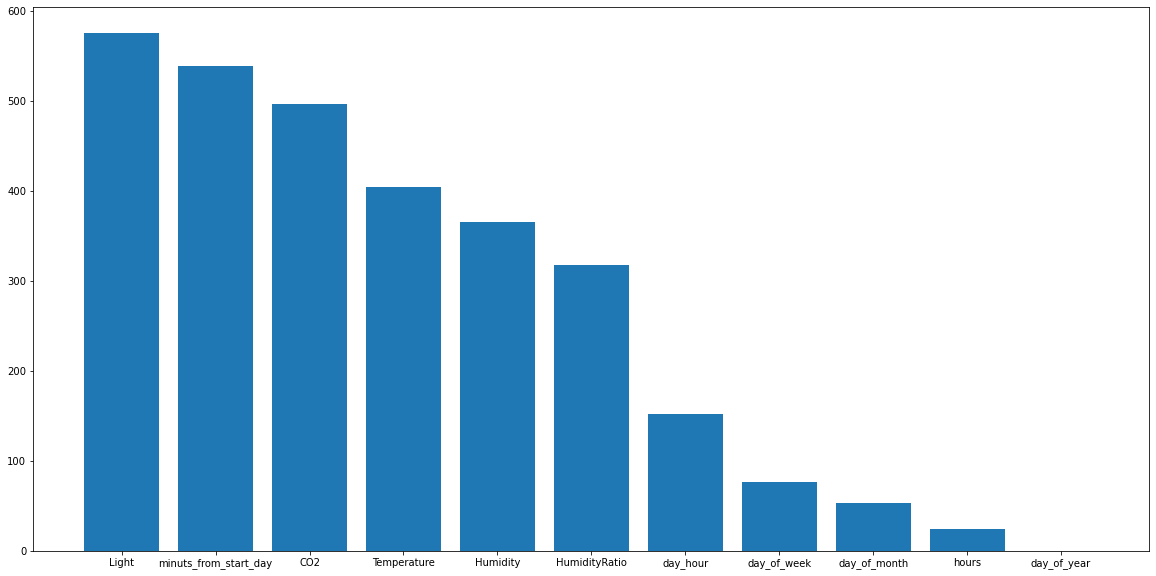


#########################################   xgb   ###################################################

roc_auc_score for -xgb : 0.9995267565002042
[('Light', 0.8237082), ('hours', 0.040635344), ('day_of_week', 0.035053693), ('day_hour', 0.033774056), ('minuts_from_start_day', 0.014876432), ('Temperature', 0.013090973), ('Humidity', 0.012061066), ('day_of_month', 0.009437352), ('CO2', 0.009226127), ('HumidityRatio', 0.0081368), ('day_of_year', 0.0)]


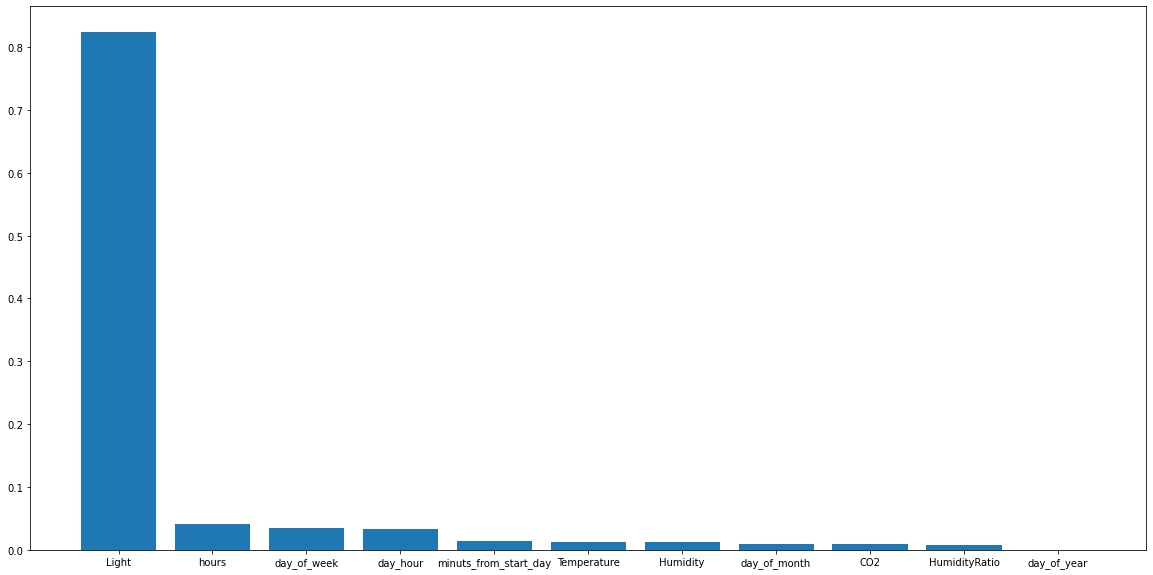


#########################################   cb   ###################################################

roc_auc_score for -cb : 0.999325240890699
[('Light', 54.293636971616465), ('minuts_from_start_day', 8.936074157776513), ('CO2', 8.13642873916028), ('HumidityRatio', 5.539976900817134), ('day_hour', 5.13305745867709), ('Humidity', 4.831777383864167), ('Temperature', 4.811140617245193), ('hours', 3.2989290102045064), ('day_of_week', 2.224210985433573), ('day_of_month', 1.590090476823488), ('day_of_year', 1.2046772983815985)]


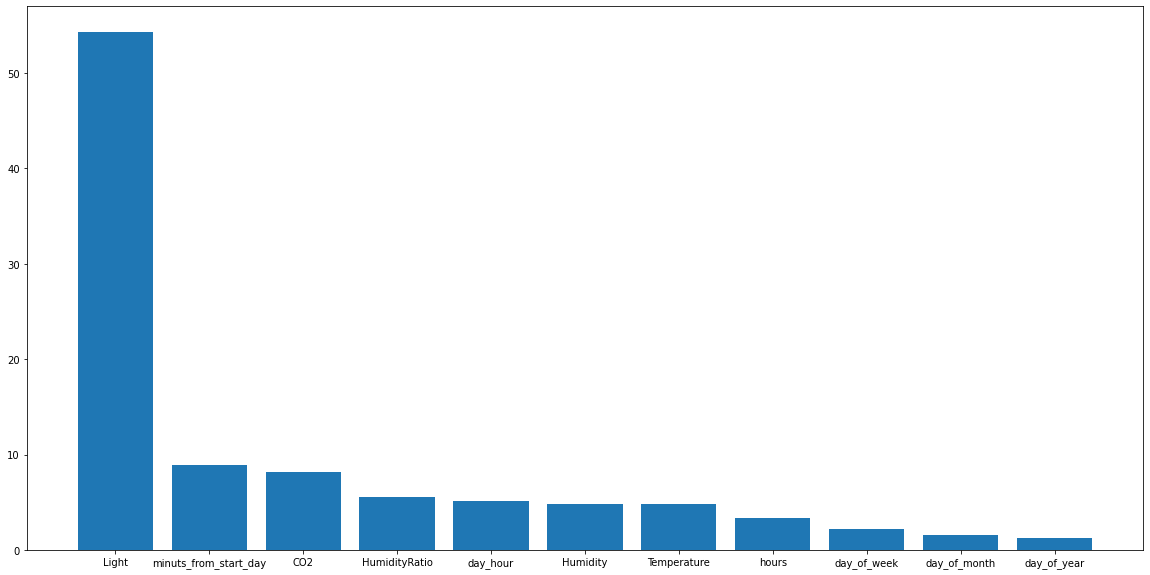

In [19]:
imp_f = test_feature_importances(estimators,columns)
    

### разобраться с SHAP и построить важности признаков для: 
всего тестового набора данных (summary_plot - дать интерпретацию)
для топ 10%  
для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


#########################################   rf   ###################################################



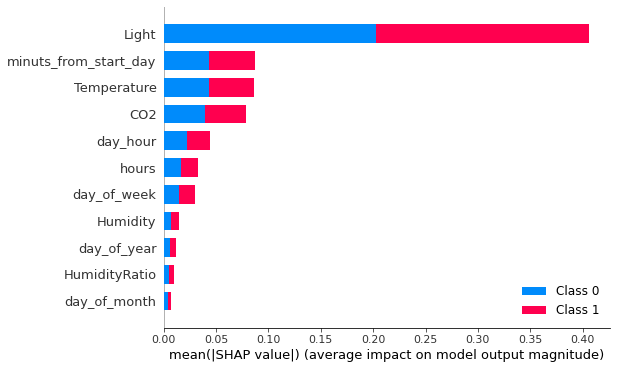

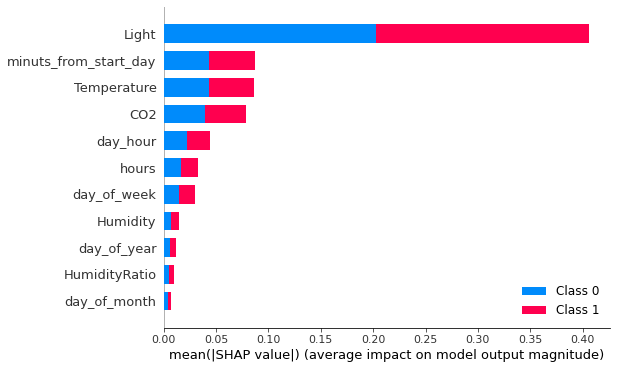


#########################################   lgb   ###################################################



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


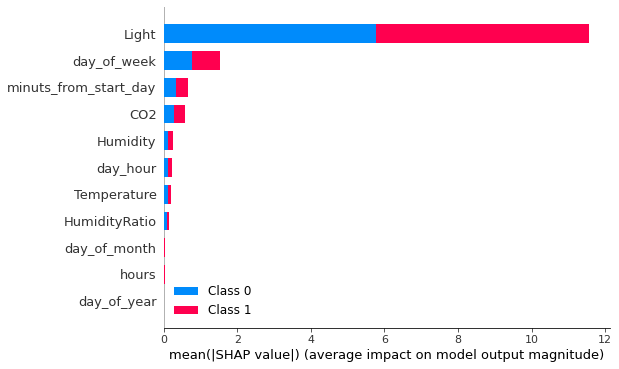

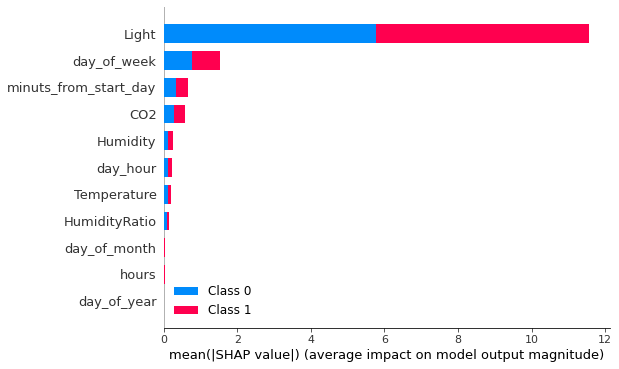


#########################################   xgb   ###################################################



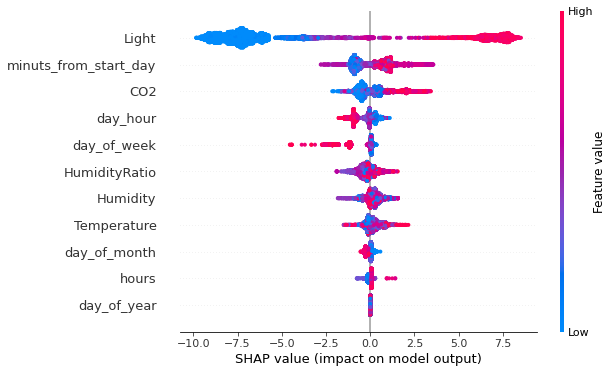

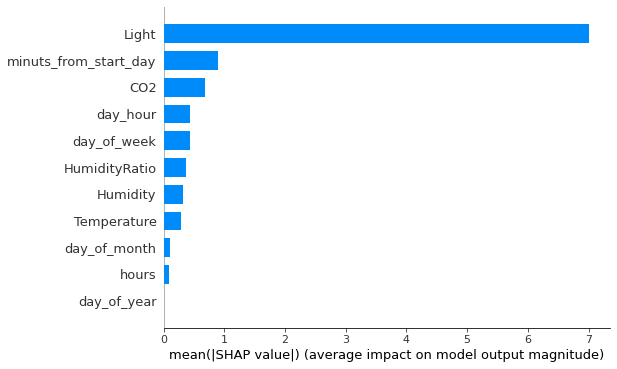


#########################################   cb   ###################################################



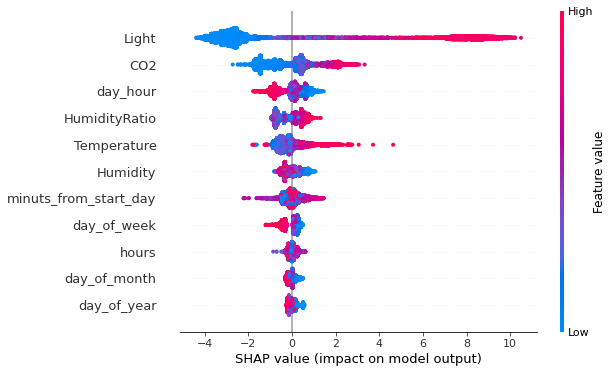

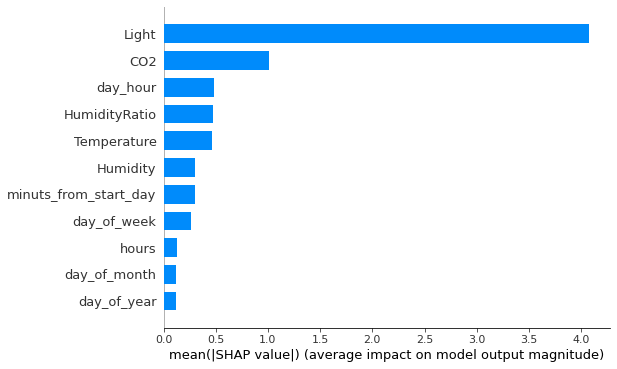

In [24]:
shap_plot_summary_for_several_models(estimators)

Самый важный признак по всем моделям это уровень освещенности. Что логично. Уходя обычно выключают свет.  
При увеличении этого показателя, после опоределенного предела резко появляются положительные значение, что видимо сведетельствует о включении света.  
При уменьшении этого показателя, так же через какаой то период происходит резкое увеличение отрицательных результатов.
Второй по важности трудно выделить. Разные модели дают его по разному, причем даже при разных random_state они разные и могут меняться месиами.   
В целом примерно одной важности следующие факторы:  
    1. Уровень CO2,сто логично, он должен снижаться когда посешение пустое , но не сразу  
    2. Это вариации времени либо сколкьоп рошло минут с начала дня, либо денеь недели и час. Что то же логично, обычно днем работаю, потом уходят, на выходные вообще не приходя


In [30]:
model = estimators[3][1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
n=10
shap.force_plot(explainer.expected_value,shap_values[:n,:],X_train.iloc[:n,:])

Первое значение (0)
Отрицательное.
Основной вклад внесли в это уровень света 50, Воскресение 15 часов дня, при этом в сторону положительного тянет уровен со2 и и температура

In [31]:
shap.force_plot(explainer.expected_value, shap_values[150,:], X_train.iloc[150,:],link='logit')

Нам попался чисто положительный вариант, ни одного отрицательного фактора.
Самы сильный это уровень света 429  
Далее минут с начала дня (шел 17-й час)  
Температура 21,89 градусов  


In [32]:
shap.force_plot(explainer.expected_value, shap_values[160,:], X_train.iloc[160,:],link='logit')

Тут уровень света все решает, далее уровень со2 (уже надышали), а так же что это вторник 11 часов дня.